## Overfitting
The network learns the training set better and bettter, resulting in lower training losses. However, it starts having problems generalizing to outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data.

One option is to use the version of the model with the lowest validation loss. This strategy is called early stopping. In practice, you'd save the model frequntly as you're training then later choose the model with lowest validation loss.

The most common method to reduce overfitting (outside of *early-stopping* ) is dropout, where we randomly drop input units.

In PyTorch: `nn.Dropout`

In [16]:
import torch
from torchvision import datasets, transforms

# Deifne a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_date1', download=True, train=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_date1', download=True, train=True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [19]:
from torch import nn, optim
import torch.nn.functional as F

# Define network architecture
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # Output so not dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        return x
    
        

In [20]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss +=loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval() # truns off the dropout
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        


Epoch: 1/30..  Training Loss: 0.601..  Test Loss: 0.422..  Test Accuracy: 0.846
Epoch: 2/30..  Training Loss: 0.479..  Test Loss: 0.392..  Test Accuracy: 0.862
Epoch: 3/30..  Training Loss: 0.451..  Test Loss: 0.370..  Test Accuracy: 0.860
Epoch: 4/30..  Training Loss: 0.434..  Test Loss: 0.361..  Test Accuracy: 0.866
Epoch: 5/30..  Training Loss: 0.422..  Test Loss: 0.330..  Test Accuracy: 0.877
Epoch: 6/30..  Training Loss: 0.406..  Test Loss: 0.334..  Test Accuracy: 0.878
Epoch: 7/30..  Training Loss: 0.403..  Test Loss: 0.319..  Test Accuracy: 0.879
Epoch: 8/30..  Training Loss: 0.394..  Test Loss: 0.322..  Test Accuracy: 0.879
Epoch: 9/30..  Training Loss: 0.399..  Test Loss: 0.321..  Test Accuracy: 0.881
Epoch: 10/30..  Training Loss: 0.393..  Test Loss: 0.311..  Test Accuracy: 0.887
Epoch: 11/30..  Training Loss: 0.385..  Test Loss: 0.311..  Test Accuracy: 0.886
Epoch: 12/30..  Training Loss: 0.378..  Test Loss: 0.313..  Test Accuracy: 0.886
Epoch: 13/30..  Training Loss: 0.372.

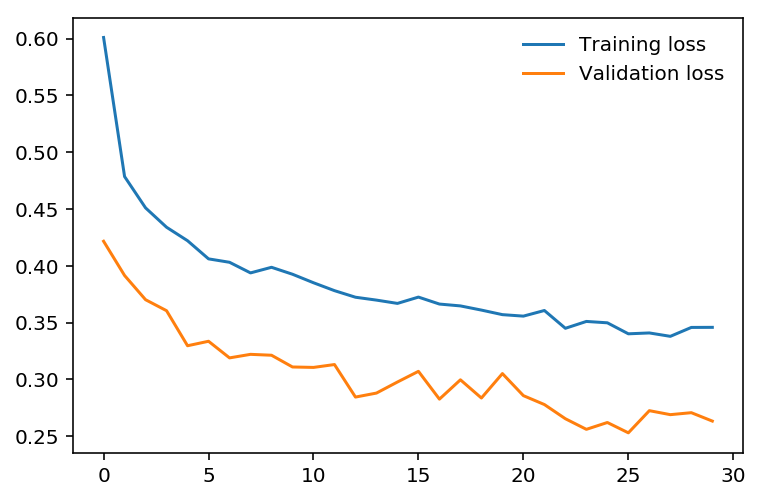

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)